This notebook will run MHI with decay specified in config, with transforms on 
- MobileNet
- Resnet50
- EfficientNetB0

Dataset is 100 samples.<br>
DECAY = 0.09<br>
FRAME_SIZE = 20<br>
BINARY_THRESHOLD = 25

In [1]:
!pip install opencv-python numpy tensorflow scikit-learn matplotlib wandb tdqm wurlitzer albumentations

# Config

In [1]:
#all the required dependencies of the project
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import random
import wandb
import pandas as pd

from typing import Tuple
from collections import Counter
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from typing import List
import json
import tensorflow.keras as keras 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from math import ceil

In [2]:
class CONFIG:
    ROOT_DIRECTORY = os.path.join("..","data","manual-script-full")

    mean=[0, 0, 0]
    std=[1, 1, 1]
    DEBUG = True
    
    P_OF_TRANSFORM = 0.8
    P_OF_TRANSFORM_COLOR = 0.2
    
    SHIFT_LIMIT=0.1
    SCALE_LIMIT=0.05
    ROTATE_LIMIT=10
    
    # set to small, when prototyping, or 0 when deploying to cloud or PC with loads of RAM
    DATA_LIMIT = 100
    VIDEO_LENGTH = 35
    
    BATCH_SIZE = 4
    PORTION_OF_DATA_FOR_TRAINING = 0.8

    ROUND_DIGIT = 3
    #WANDB_RUN = "mediapipe-asl-dataset"
    DECAY = 0.09
    
    USE_WANDB = True

    WANDB_RUN = "MHI-CNN"

## Utils

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
from wandb.keras import WandbMetricsLogger
import tensorflow as tf
import wandb
from math import sqrt


def visualize_video(frames, save_path=None, mult=2, show=True):

    # calculate the grid
    image_cnt = frames.shape[0]
    rounded_cnt = ceil(sqrt(image_cnt))

    # calculate the width/height ratio
    ratio = frames.shape[1] / frames.shape[2]

    # create grid of arrays
    fig, axs = plt.subplots(rounded_cnt, rounded_cnt, figsize=( rounded_cnt*mult, ratio * rounded_cnt*mult))
    axs_flat = axs.flatten()

    # Loop through images and display each
    for i in range(rounded_cnt * rounded_cnt):
        if i < len(frames):
            axs_flat[i].imshow(frames[i])
        axs_flat[i].axis('off')  # Turn off axis
        axs_flat[i].set_title(i)

    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')        
    
    if show:
        plt.show()
    else:
        plt.close()


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, run_name : str,
                train_ds, val_ds, dataset_name,
                max_lr = 1e-4, min_lr = 5e-5,
                T_max=50, epochs=100,
                decay = 0.09,USE_WANDB=True): 
    
    global train_ds_len, val_ds_len, unique_labels_num
   
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)

    callbacks = [checkpoint]#, cosine_annealer]

    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : min_lr, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : train_ds_len,
                                "val_size" : val_ds_len,
                                "unique_classes" : unique_labels_num, 
                                "video_length" : CONFIG.FRAME_SIZE,
                                "decay" : decay,
                                "SHIFT_LIMIT" : CONFIG.SHIFT_LIMIT,
                                "SCALE_LIMIT" : CONFIG.SCALE_LIMIT,
                                "ROTATE_LIMIT" : CONFIG.ROTATE_LIMIT,
                                "CACHEING" : dataset_name
                               })
        callbacks.append(WandbMetricsLogger())
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)
    #lr_metric = get_lr_metric(adam_optimizer)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    #history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, batch_size = 8, callbacks=[WandbMetricsLogger(), checkpoint, cosine_annealer])
    history = model.fit(train_ds, epochs=epochs, validation_data = val_ds, batch_size = CONFIG.BATCH_SIZE, callbacks=callbacks)
    #wandb.finish()
    if USE_WANDB:      
        wandb.finish()
    
    return history

# Cacheing Dataset definition

## Dataset definitions

In [4]:

def frame_diff2(prev, curr, kernel=np.array((5, 5), dtype=np.uint8),
                filter_size=3, filter_size_post=3, blocksize=15, C=3):
    frame_diff = cv2.subtract(curr, prev)
    frame_diff = cv2.medianBlur(frame_diff, filter_size)
    mask = cv2.adaptiveThreshold(frame_diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, blocksize, C)
    mask = cv2.medianBlur(mask, filter_size_post)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    return mask

def pseudocolor_generator(X, v1, v2, v3, v1_node, v2_node, v3_node, pow=1):
    I = X.astype(float) / 255.

    s1 = np.clip(1 - ((1. / ((v1_node - v1) ** 2)) * (v1 - I) ** 2) ** pow, 0, 1)
    s2 = np.clip(1 - ((1. / ((v2_node - v2) ** 2)) * (v2 - I) ** 2) ** pow, 0, 1)
    s3 = np.clip(1 - ((1. / ((v3_node - v3) ** 2)) * (v3 - I) ** 2) ** pow, 0, 1)

    ret = np.stack([s3, s2, s1], axis=2)

    return ret

def MHI_1(prev_mhi, frame_diff, tau=255, delta=32):
    next_MHI = np.zeros_like(prev_mhi).astype(int)

    next_MHI[frame_diff == 255] = tau
    next_MHI[frame_diff != 255] = np.clip(prev_mhi[frame_diff != 255].astype(int) - delta, 0, 255)

    return np.clip(next_MHI, 0, 255).astype(np.uint8)


def MHI_from_trajectory(traj : np.ndarray, tau : int, delta : int) -> np.ndarray:
    # timeframe, Width, height, channels
    ts, w, h, c = traj.shape
                        
    prev = np.zeros(shape=(w, h))
    mhi = None
        
    for i in range(1, ts):
        
        _prev = cv2.cvtColor((traj[i-1]).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        _curr = cv2.cvtColor((traj[i]).astype(np.uint8), cv2.COLOR_BGR2GRAY)
            
        fd = frame_diff2(prev=_prev,curr=_curr)
        mhi = MHI_1(prev, fd, tau=tau, delta=delta)

        prev = mhi

    return mhi
    
    
def twosum_from_trajectory(traj : np.ndarray) -> np.ndarray:
    return traj

class BSLSignRecognitionDataset(keras.utils.Sequence):

    def __init__(self, cache_mode : str, 
                 is_dataset_for_training : bool,
                 video_length :  int = CONFIG.VIDEO_LENGTH,
                 post_mode : str = "identity",
                 tau :int = 255,
                 delta : int = 8,
                 v1 : float = 1/3, v2 : float = 2/3, v3 = 1.,
                 v1_node = 0, v2_node = 1, v3_node = 0.5, pow=1,
                 desired_shape = (224, 224)) -> None:
        # setup the paths
        
        self.unique_labels = []
        self.video_paths = []
        self.classes = []
        self.is_dataset_for_training = is_dataset_for_training
        self.video_length = video_length
        self.desired_shape = desired_shape
        self.cache_mode = cache_mode
        self.post_mode = post_mode
        self.tau = tau
        self.delta = delta
        self.v1, self.v2, self.v3 = v1, v2, v3
        self.v1_node, self.v2_node, self.v3_node = v1_node, v2_node, v3_node
        self.pow = pow
        self.mean = np.array([0.,0.,0.])
        self.std  = np.array([0.,0.,0.])
        self.cnt = 0

        for i,_class in enumerate(os.listdir(os.path.join(".", CONFIG.ROOT_DIRECTORY))):
            self.unique_labels.append(_class)
            
            for video in os.listdir(os.path.join(".", CONFIG.ROOT_DIRECTORY, _class)):
                self.video_paths.append(os.path.join( ".", CONFIG.ROOT_DIRECTORY, _class, video ))  
                self.classes.append(i)
                
        
        self.video_paths, self.classes = np.array(self.video_paths), np.array(self.classes)
        self._dataset = np.concatenate([ self.video_paths[:, np.newaxis], self.classes[:, np.newaxis] ], axis=1)
                

        train_ds, val_ds = train_test_split(self._dataset, train_size=CONFIG.PORTION_OF_DATA_FOR_TRAINING, 
                                            random_state=42, stratify=self._dataset[:, 1])
    

        if is_dataset_for_training == True:
            self.dataset = train_ds
        else:
            self.dataset = val_ds
    
        self.cache_dataset()    
        self.calculate_dataset_properties()    
    
    def cache_dataset(self):
        
        self.cached_X, self.cached_Y = [], []
        
        for point in tqdm(self.dataset, desc="Cacheing"):
            video_path, y = point
            trajectory = self.rescale_video(BSLSignRecognitionDataset.get_video(video_path),
                                            desired_shape=self.desired_shape)
            
            hotencoded = np.zeros(len(self.unique_labels))
            hotencoded[int(y)] = 1
            
            self.add_trajectory(trajectory, hotencoded)
            
    def calculate_dataset_properties(self):
        for el in self.cached_X:
            l = el.shape
            self.mean += np.sum( el, axis=tuple( l[:-1] ) )
            self.cnt += np.prod(l[:-1])     
        self.mean /= self.cnt

        for el in self.cached_X:
             l = el.shape
             self.std += np.sum( (el - self.mean)**2, axis=tuple(l[:-1]))
        self.std = np.sqrt(self.std / self.cnt)
        
    def normalize_data(self):
        for i in range(len(self.cached_X)):
            self.cached_X[i] = (self.cached_X - self.mean) / self.std
                            
    def add_trajectory(self, traj : List[np.ndarray], label : np.ndarray):
        t, w, h, c = traj.shape       
 
        if self.cache_mode.lower() == "rgb":
            self.cached_X.append(traj.astype(float) / 255.)
            self.cached_Y.append(label)    
        
        elif self.cache_mode.lower() == "mhi":
            computed = []
            if t < self.video_length:
                computed.append(MHI_from_trajectory(traj, tau=self.tau, delta=self.delta).astype(float) / 255.)
            else:
                for i in range(t - self.video_length + 1):
                    computed.append(MHI_from_trajectory(traj[i : (i+self.video_length)], tau=self.tau, delta=self.delta).astype(float) / 255.)
            
            self.cached_X.append(np.array(computed))
            self.cached_Y.append(label)            
        
        elif self.cache_mode.lower() == "pseudocolor":
            computed = []
            if t < self.video_length:
                MHI = MHI_from_trajectory(traj, tau=self.tau, delta=self.delta)
                computed.append(pseudocolor_generator(MHI, self.v1, self.v2, self.v3, self.v1_node, self.v2_node, self.v3_node, pow=self.pow))
            else:
                for i in range(t - self.video_length + 1):
                    MHI = MHI_from_trajectory(traj[i : (i+self.video_length)], tau=self.tau, delta=self.delta)
                    computed.append(pseudocolor_generator(MHI, self.v1, self.v2, self.v3, self.v1_node, self.v2_node, self.v3_node, pow=self.pow))
            
            self.cached_X.append(np.array(computed))
            self.cached_Y.append(label)            
        
        elif self.cache_mode.lower() == "twosum-concat":
            return traj
                
        elif self.cache_mode.lower() == "twosum-stream":
            return traj
        elif self.cache_mode.lower() == "twosum-3d":
            return traj
        else:
            raise Exception(f"mode should be one of ['rgb', 'mhi', 'twosum-concat', 'twosum-stream', 'twosum-2d' 'pseudocolor']")        
        
    
    def preprocess_trajectory(self, traj : np.ndarray):
        return traj
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        datapoint, label = self.select(self.cached_X[idx]), self.cached_Y[idx]
        
        return datapoint, label


    def select(self, trajectory : np.array) -> np.array:
        
        
        if self.cache_mode.lower() == "rgb" or self.cache_mode.lower().startswith("twosum"):        
            if self.video_length != 0:
                frame_size = len(trajectory)
                start = 0 
                
                if frame_size > self.video_length:
                    start = np.random.randint(0, frame_size - self.video_length)
                trajectory = trajectory[start: (start + self.video_length)]
                        
                if len(trajectory) < self.video_length:
                    necessary = self.video_length - len(trajectory)
                    t, h, w, c = trajectory.shape
                    trajectory = np.concatenate([trajectory, np.zeros((necessary, h, w, c))], axis= 0)
                    
                return trajectory
            
        elif self.cache_mode.lower() == "mhi" or self.cache_mode.lower() == "pseudocolor":
            length = len(trajectory)
            return trajectory[np.random.randint(length)]
        
        else:
            raise Exception(f"mode should be one of ['rgb', 'mhi', 'twosum-concat', 'twosum-stream', 'twosum-2d' 'pseudocolor']")        
                
                
    @staticmethod
    def get_video(video_path : str) -> List[np.ndarray]:

        if not os.path.exists(video_path):
            return None

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None

        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame_array = np.array(frame)
                frames.append(cv2.cvtColor(frame_array, cv2.COLOR_BGR2RGB))
            else:
                break

        cap.release()
        return np.array(frames)

    @staticmethod
    def rescale_video(frames : np.ndarray, desired_shape) -> np.ndarray:
        refined = []
        for img in frames: 
            y, x, c = img.shape
            cropped = img[:, (x // 2 - y//2) : (x // 2 + y//2), :]
            scaled = cv2.resize(cropped, desired_shape)
            refined.append(scaled)
    
        return np.array(refined)



transform = A.Compose(
    [
        A.Normalize(mean=CONFIG.mean, std=CONFIG.std),
        #A.HorizontalFlip(p=CONFIG.P_OF_TRANSFORM),
        #A.ShiftScaleRotate(p=CONFIG.P_OF_TRANSFORM, shift_limit=CONFIG.SHIFT_LIMIT, 
        #                   scale_limit=CONFIG.SCALE_LIMIT, rotate_limit=CONFIG.ROTATE_LIMIT),
        #A.RandomBrightnessContrast(p=CONFIG.P_OF_TRANSFORM_COLOR),
        #A.RGBShift(p=CONFIG.P_OF_TRANSFORM_COLOR),
    ]
)

tau, delta = 255, 10

train_ds_rgb = BSLSignRecognitionDataset(cache_mode="rgb", is_dataset_for_training=True)
val_ds_rgb   = BSLSignRecognitionDataset(cache_mode="rgb", is_dataset_for_training=False)

train_ds = BSLSignRecognitionDataset(cache_mode="pseudocolor", tau=tau, delta=delta, is_dataset_for_training=True)
val_ds   = BSLSignRecognitionDataset(cache_mode="pseudocolor", tau=tau, delta=delta, is_dataset_for_training=False)


train_ds_len = len(train_ds)
val_ds_len = len(val_ds)
unique_labels_num = len(train_ds.unique_labels)

print(f"size of train_ds = {len(train_ds)}, size of val_ds = {len(val_ds)}")

Cacheing: 100%|██████████| 40/40 [00:17<00:00,  2.25it/s]

size of train_ds = 160, size of val_ds = 40


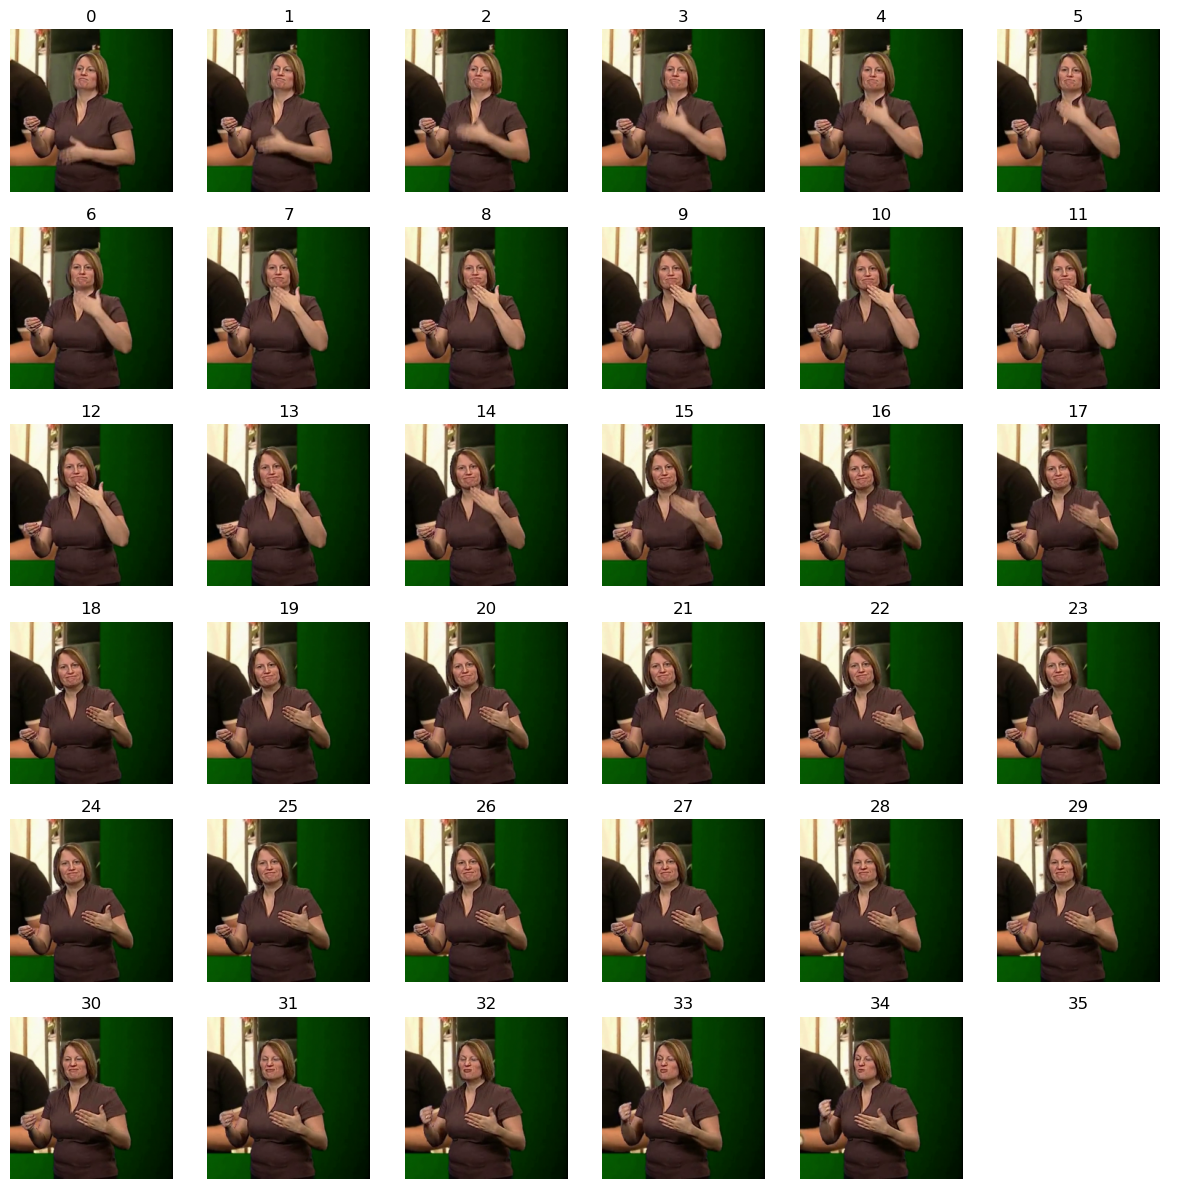

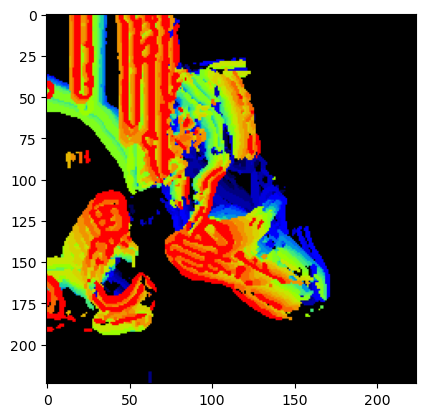

In [6]:
idx = 5
visualize_video(train_ds_rgb[idx][0])
plt.imshow(train_ds[idx][0])

In [7]:
print(train_ds.unique_labels)

['sorry', 'thanks']


In [20]:
def dataset_train_generator():
    # Instantiate your existing dataset loader

    for i in range(len(train_ds)):
        X_batch, Y_batch = train_ds[i]
        yield X_batch, Y_batch
        
def dataset_val_generator():
    # Instantiate your existing dataset loader

    for i in range(len(val_ds)):
        X_batch, Y_batch = val_ds[i]
        yield X_batch, Y_batch        

train_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_train_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(x_shape, y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_val_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(x_shape, y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

In [22]:
train_labels = []
val_labels = []
nans = False

for x, y in tqdm(train_dataset, desc="iterating through train dataset"):
    labels = np.argmax(y, axis=1)
    for l in labels:
        train_labels.append(l)

    nans |= np.any(np.isnan(x))
print(f"nans = {nans}")        

for x, y in tqdm(val_dataset, desc="iterating through val dataset"):
    labels = np.argmax(y, axis=1)
    for l in labels:
        val_labels.append(l)
print(f"nans = {nans}")        

iterating through train dataset: 1223it [00:03, 308.43it/s]


nans = False


iterating through val dataset: 305it [00:01, 300.29it/s]

nans = False


E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


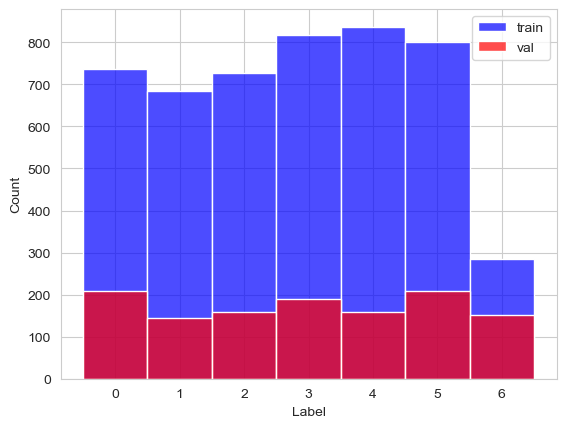

In [23]:
import seaborn as sns 

train_df_labels = pd.DataFrame(train_labels, columns=['Label'])
val_df_labels = pd.DataFrame(val_labels, columns=['Label'])


sns.histplot(train_df_labels, x="Label", alpha=0.7, discrete=True, kde=False, color="blue", label="train")
sns.histplot(val_df_labels, x="Label", alpha=0.7,discrete=True, kde=False, color="red", label="val")
plt.legend()
plt.show()

## run the experiments

### MobileNetV3

In [31]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.MobileNetV3Small(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, run_name="C2_MobileNetV3Small_augmentation_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            max_lr = 1e-4, 
            min_lr = 5e-5,
            T_max=21, 
            epochs=40,
            filepath=os.path.join("models", "C2_MobileNetV3Small_no_transforms.keras"), 
            USE_WANDB=False)

Epoch 1/40
   1223/Unknown 120s 68ms/step - categorical_accuracy: 0.3572 - loss: 7.1677

E:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1223/1223 ━━━━━━━━━━━━━━━━━━━━ 128s 75ms/step - categorical_accuracy: 0.3572 - loss: 7.1659 - val_categorical_accuracy: 0.1716 - val_loss: 2.8431
Epoch 2/40
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 93s 76ms/step - categorical_accuracy: 0.2486 - loss: 2.0624 - val_categorical_accuracy: 0.1182 - val_loss: 2.1417
Epoch 3/40
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 88s 72ms/step - categorical_accuracy: 0.2119 - loss: 2.0169 - val_categorical_accuracy: 0.1182 - val_loss: 2.0302
Epoch 4/40
 372/1223 ━━━━━━━━━━━━━━━━━━━━ 1:02 73ms/step - categorical_accuracy: 0.2352 - loss: 2.2872


KeyboardInterrupt



### Resnet50

In [ ]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.ResNet50(input_shape = MHI_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, 
            run_name="C2_Resnet50_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            T_max=251, 
            epochs=500,
            max_lr = 0.75e-4, 
            min_lr = 2.5e-5,
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            filepath=os.path.join("models", "MHI_Resnet50_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

Epoch 1/500
     20/Unknown - 27s 59ms/step - loss: 2.5596 - categorical_accuracy: 0.1750

2024-04-15 19:06:44.268103: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7827257057883545257
2024-04-15 19:06:44.268228: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8940206431827680969


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 44s 931ms/step - loss: 2.5596 - categorical_accuracy: 0.1750 - val_loss: 2.8761 - val_categorical_accuracy: 0.2000
Epoch 2/500
20/20 [==============================] - 1s 58ms/step - loss: 2.1957 - categorical_accuracy: 0.2250 - val_loss: 2.9090 - val_categorical_accuracy: 0.2000
Epoch 3/500
20/20 [==============================] - 1s 58ms/step - loss: 2.0456 - categorical_accuracy: 0.2375 - val_loss: 2.3261 - val_categorical_accuracy: 0.2000
Epoch 4/500
20/20 [==============================] - 1s 64ms/step - loss: 2.0417 - categorical_accuracy: 0.2750 - val_loss: 2.3356 - val_categorical_accuracy: 0.2000
Epoch 5/500
20/20 [==============================] - 1s 64ms/step - loss: 1.7729 - categorical_accuracy: 0.3875 - val_loss: 4.5294 - val_categorical_accuracy: 0.2000
Epoch 6/500
20/20 [==============================] - 1s 63ms/step - loss: 1.8547 - categorical_accuracy: 0.3000 - val_loss: 4.1211 - val_categorical_accuracy: 0.2000
Epoch 7/500
20

INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 19s 1s/step - loss: 0.1563 - categorical_accuracy: 0.9625 - val_loss: 19.2733 - val_categorical_accuracy: 0.2500
Epoch 62/500
20/20 [==============================] - ETA: 0s - loss: 0.2343 - categorical_accuracy: 0.9500INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


INFO:tensorflow:Assets written to: models/MHI_Resnet50.tf/assets


20/20 [==============================] - 19s 1s/step - loss: 0.2343 - categorical_accuracy: 0.9500 - val_loss: 20.3617 - val_categorical_accuracy: 0.3000
Epoch 63/500
20/20 [==============================] - 1s 59ms/step - loss: 0.2062 - categorical_accuracy: 0.9625 - val_loss: 18.3190 - val_categorical_accuracy: 0.2500
Epoch 64/500
20/20 [==============================] - 1s 59ms/step - loss: 0.0724 - categorical_accuracy: 0.9875 - val_loss: 21.3327 - val_categorical_accuracy: 0.2000
Epoch 65/500
20/20 [==============================] - 1s 59ms/step - loss: 0.0748 - categorical_accuracy: 0.9875 - val_loss: 27.8325 - val_categorical_accuracy: 0.2000
Epoch 66/500
20/20 [==============================] - 1s 60ms/step - loss: 0.1365 - categorical_accuracy: 0.9500 - val_loss: 25.7577 - val_categorical_accuracy: 0.2000
Epoch 67/500
20/20 [==============================] - 1s 63ms/step - loss: 0.1439 - categorical_accuracy: 0.9500 - val_loss: 21.3883 - val_categorical_accuracy: 0.1500
Epoch 

### EfficientNetB0

In [44]:
MHI_SHAPE = (224,224,3)
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.EfficientNetB0(input_shape = MHI_SHAPE,
                                                include_top = False,
                                                weights = 'imagenet',
                                                pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, 
            run_name="C2_EfficientNetB0_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            T_max=501, 
            epochs=1000,
            max_lr = 1e-4, 
            min_lr = 1e-5,
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            filepath=os.path.join("models", "C2_EfficientNetB0_no_transforms.tf"), 
            USE_WANDB=CONFIG.USE_WANDB)

epoch/categorical_accuracy,▁▃▁▅▆▄▇▅▆█▅▅▄█▅▆▇█▃
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
epoch/learning_rate,█████▇▇▇▆▆▆▅▅▄▄▃▂▂▁
epoch/loss,█▇▅▅▅▅▃▄▃▃▃▃▄▁▄▁▂▂▄
epoch/val_categorical_accuracy,▂▄▂▅█▂▄▄▅▄▅▂▅▄█▇▄▁▄
epoch/val_loss,▂▃▄▄▅▂▆█▇▄▅▆▄▂▂▁▄▅█
epoch/categorical_accuracy,0.1875
epoch/epoch,18
epoch/learning_rate,0.0001
epoch/loss,1.92845
epoch/val_categorical_accuracy,0.15


Epoch 1/1000
     19/Unknown - 1s 12ms/step - loss: 2.5541 - categorical_accuracy: 0.1447

2024-04-15 20:25:12.610324: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3349952044877754649
2024-04-15 20:25:12.610375: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14498149272523616542
2024-04-15 20:25:12.610405: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14133121464649995126


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


2024-04-15 20:25:12.840681: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3349952044877754649
2024-04-15 20:25:12.840769: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6630784775236842777
2024-04-15 20:25:12.840846: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4556428208539362992
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 2s 76ms/step - loss: 2.5875 - categorical_accuracy: 0.1375 - val_loss: 2.3158 - val_categorical_accuracy: 0.0500
Epoch 2/1000
19/20 [===========================>..] - ETA: 0s - loss: 2.0391 - categorical_accuracy: 0.1579INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 64ms/step - loss: 2.0335 - categorical_accuracy: 0.1500 - val_loss: 2.0524 - val_categorical_accuracy: 0.3000
Epoch 3/1000
20/20 [==============================] - 0s 15ms/step - loss: 2.0073 - categorical_accuracy: 0.2375 - val_loss: 2.0798 - val_categorical_accuracy: 0.1000
Epoch 4/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.8469 - categorical_accuracy: 0.3000 - val_loss: 2.2172 - val_categorical_accuracy: 0.0500
Epoch 5/1000
20/20 [==============================] - 0s 16ms/step - loss: 1.8352 - categorical_accuracy: 0.3250 - val_loss: 2.0751 - val_categorical_accuracy: 0.2000
Epoch 6/1000
20/20 [==============================] - 0s 16ms/step - loss: 1.7232 - categorical_accuracy: 0.2500 - val_loss: 2.2522 - val_categorical_accuracy: 0.1000
Epoch 7/1000
20/20 [==============================] - 0s 16ms/step - loss: 1.7331 - categorical_accuracy: 0.3625 - val_loss: 2.3925 - val_categorical_accuracy: 0.1500
Epoch 8/100

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 66ms/step - loss: 1.4061 - categorical_accuracy: 0.5125 - val_loss: 1.9711 - val_categorical_accuracy: 0.3500
Epoch 65/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.5720 - categorical_accuracy: 0.4500 - val_loss: 2.4768 - val_categorical_accuracy: 0.0500
Epoch 66/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.3005 - categorical_accuracy: 0.5375 - val_loss: 2.0595 - val_categorical_accuracy: 0.0500
Epoch 67/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.3653 - categorical_accuracy: 0.5250 - val_loss: 2.3544 - val_categorical_accuracy: 0.1000
Epoch 68/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.4216 - categorical_accuracy: 0.5125 - val_loss: 2.3392 - val_categorical_accuracy: 0.1000
Epoch 69/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.3836 - categorical_accuracy: 0.5250 - val_loss: 2.1411 - val_categorical_accuracy: 0.1500
Epoch 

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 65ms/step - loss: 1.2883 - categorical_accuracy: 0.5500 - val_loss: 1.8682 - val_categorical_accuracy: 0.4000
Epoch 224/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.3855 - categorical_accuracy: 0.5375 - val_loss: 2.6614 - val_categorical_accuracy: 0.1500
Epoch 225/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.2329 - categorical_accuracy: 0.6375 - val_loss: 2.2735 - val_categorical_accuracy: 0.2000
Epoch 226/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.2806 - categorical_accuracy: 0.5750 - val_loss: 2.0813 - val_categorical_accuracy: 0.2500
Epoch 227/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.3486 - categorical_accuracy: 0.5375 - val_loss: 2.1293 - val_categorical_accuracy: 0.1500
Epoch 228/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.2421 - categorical_accuracy: 0.6250 - val_loss: 2.1897 - val_categorical_accuracy: 0.1500
E

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(150528, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe258581790>, 140610031114224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c588790>, 140610031311072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe26c368ad0>, 140610035535184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6c4390>, 140610035539696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256, 7), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6e7450>, 140610031314672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(7,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fe23c6b7ad0>, 140610030804768), {}).


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


INFO:tensorflow:Assets written to: models/C2_EfficientNetB0.tf/assets


20/20 [==============================] - 1s 62ms/step - loss: 1.1632 - categorical_accuracy: 0.5750 - val_loss: 1.9265 - val_categorical_accuracy: 0.4500
Epoch 398/1000
20/20 [==============================] - 0s 18ms/step - loss: 1.2471 - categorical_accuracy: 0.6250 - val_loss: 2.1876 - val_categorical_accuracy: 0.2000
Epoch 399/1000
20/20 [==============================] - 0s 19ms/step - loss: 1.0265 - categorical_accuracy: 0.6500 - val_loss: 2.2331 - val_categorical_accuracy: 0.0000e+00
Epoch 400/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.2082 - categorical_accuracy: 0.6125 - val_loss: 2.5326 - val_categorical_accuracy: 0.2000
Epoch 401/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.1866 - categorical_accuracy: 0.6000 - val_loss: 2.3005 - val_categorical_accuracy: 0.2000
Epoch 402/1000
20/20 [==============================] - 0s 17ms/step - loss: 1.2886 - categorical_accuracy: 0.5750 - val_loss: 2.5169 - val_categorical_accuracy: 0.10

epoch/categorical_accuracy,▁▁▂▃▃▅▄▃▃▃▅▅▅▇▆▇▆▆▆▆▆▅▃▇▅▅▆▆▆▇█▆▆▇█▇▇▇▅▆
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,████▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
epoch/loss,█▇▅▅▆▄▅▅▅▅▃▄▄▂▃▂▃▂▂▃▃▅▅▂▃▂▃▂▃▂▂▂▁▁▁▂▂▁▄▂
epoch/val_categorical_accuracy,▆▃▃▂▃▅▄▃▄▃▂▄▂▃▃▅▂▅▃▄▄▃▂▁▂▄▅█▇▂▃▅▄▃▅▄▃▂▂▄
epoch/val_loss,▂▅▄▇▅▁▄▆▃▃▅▂▄▅▅▅▅▄▅▅▆▇▆▆▄▅▃▄▃▆▆▄▅█▅▆▇▆█▇
epoch/categorical_accuracy,0.6125
epoch/epoch,999
epoch/learning_rate,1e-05
epoch/loss,1.21336
epoch/val_categorical_accuracy,0.15
